In [1]:
import numpy as np
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Model

from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

Segmentation Models: using `tf.keras` framework.


In [2]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-v2r0nb58
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-v2r0nb58
  Running command git submodule update --init --recursive -q
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-cp37-none-any.whl size=33794 sha256=d049f5ea374bb38b89f00fe75e7ee28d5d402f6d2f0a87e1f7460044ad296eb5
  Stored in directory: /tmp/pip-ephem-wheel-cache-4gjr_p7d/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models


In [3]:
with open('x_train.npy', 'rb') as f:
    x_train = np.load(f)

with open('y_train.npy', 'rb') as f:
    y_train = np.load(f)

In [4]:
import matplotlib.pyplot as plt

In [5]:
def showImg(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()

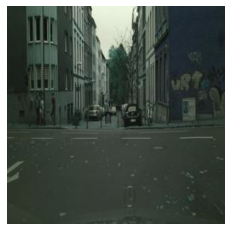

In [6]:
showImg(x_train[0])

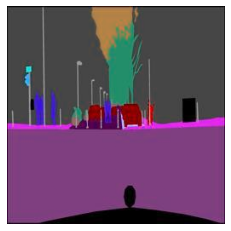

In [7]:
showImg(y_train[0])

In [8]:
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Model

from segmentation_models import Unet
from segmentation_models import get_preprocessing

In [9]:
import os

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
path = 'drive/My Drive/cityscapes_data/'

In [12]:
masks = os.listdir(path + 'y_val')

In [13]:
original = os.listdir(path + 'x_val')

In [14]:
masks.sort()
original.sort()

In [15]:
image_height = 256
image_width = 256

In [16]:
import cv2

In [17]:
x_val = np.zeros((len(original),image_height,image_width,3),dtype=np.float32)
y_val = np.zeros((len(masks),image_height,image_width,3),dtype=np.float32)

for file in original:
    n = original.index(file)
    path1 = os.path.join(path + 'x_val',file)
    img = cv2.imread(path1,1)
    try:
        img = cv2.resize(img,(256,256))
        x_val[n] = img/255
        file2 = masks[n]
        path2 = os.path.join(path + 'y_val',file2)
        mask = np.array(cv2.imread(path2,1))
        mask = cv2.resize(mask,(256,256))
        y_val[n] = mask/255
    except Exception as e:
        print(e)
        print(path1)

In [18]:
backbone = 'resnet34'
preprocess_input = get_preprocessing(backbone)

In [19]:
x_train.shape

(5950, 256, 256, 3)

In [20]:
#session is crashing due to less ram so i am taking only 1,000 images
X_train = x_train[:1000]
Y_train = y_train[:1000]
X_val = x_val[:100]
Y_val = y_val[:100]

In [21]:
del x_train
del y_train
del x_val
del y_val

In [22]:
print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)

(1000, 256, 256, 3) (1000, 256, 256, 3)
(100, 256, 256, 3) (100, 256, 256, 3)


In [23]:
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)

In [24]:
N = X_train.shape[-1]

In [25]:
base_model = Unet(backbone_name='inceptionv3',encoder_weights='imagenet')

In [26]:
inp = Input(shape=(256,256,N))
l1 = Conv2D(3,(1,1))(inp)
out = base_model(l1)
l2 = Conv2D(3,(1,1))(out)
model = Model(inp,l2,name=base_model.name)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 256, 256, 3)       12        
_________________________________________________________________
model (Model)                multiple                  29933105  
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 256, 256, 3)       6         
Total params: 29,933,123
Trainable params: 29,896,707
Non-trainable params: 36,416
_________________________________________________________________


In [27]:
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 multiple             864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma multiple             96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         multiple             0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [28]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

In [29]:
def dice_coefficient(y_true,y_pred):
    num = 2*tf.reduce_sum(y_true*y_pred)
    deno = tf.reduce_sum(y_true+y_pred)
    return num/(deno + tf.keras.backend.epsilon())

In [30]:
model.compile('Adam',loss = binary_crossentropy,metrics=[dice_coefficient])

In [32]:
#session is crashing due to less ram
#I am using google collab to train my network but still the session is crashing even after redusing the number of training and testing images

In [ ]:
model.fit(x=X_train,y=Y_train,batch_size=10,epochs=100,validation_data=(X_val,Y_val))

Train on 1000 samples, validate on 100 samples
Epoch 1/100
